In [15]:
import os

import geopandas as gpd
import descartes
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [16]:
#shapefile = os.path.join("..", "data", "boundaries", "uk_generalized_2015.shp")
shapefile = Path("../data/boundaries/uk_generalized_2015.shp")

In [17]:
map_df = gpd.read_file(shapefile).drop(["objectid"], axis=1).rename(columns={"pcon15nm":"constituency"})

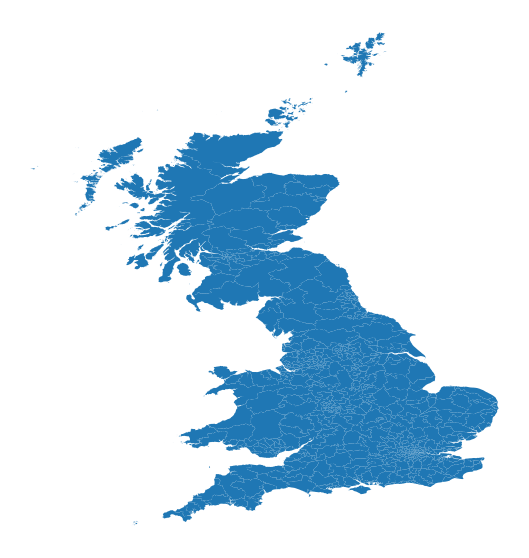

In [18]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax = map_df.plot(ax=ax)
ax.set_axis_off()

In [19]:
#datafile = os.path.join("..", "data", "information", "2019_3_28_8_14_constituency241584.csv")
datafile = Path("../data/map/241584/241584_1553701502.csv")
data_df = pd.read_csv(datafile, encoding='latin-1').drop(["ons_code"], axis=1)
print(data_df.head())

                        name                    mp  signature_count
0             Edinburgh East     Tommy Sheppard MP            18861
1  Edinburgh North and Leith       Deidre Brock MP            27216
2            Edinburgh South         Ian Murray MP            19999
3       Edinburgh South West   Joanna Cherry QC MP            17246
4             Edinburgh West  Christine Jardine MP            14670


In [20]:
print(data_df.isna().sum())

name               0
mp                 1
signature_count    0
dtype: int64


In [21]:
data_df = data_df.fillna("No MP")

In [22]:
print(map_df.head())

    pcon15cd              constituency    st_areasha     st_lengths  \
0  E14000530                 Aldershot  5.297815e+07   42197.629271   
1  E14000531       Aldridge-Brownhills  4.401654e+07   38590.183714   
2  E14000532  Altrincham and Sale West  5.092937e+07   47813.461413   
3  E14000533              Amber Valley  1.246464e+08   64665.130033   
4  E14000534   Arundel and South Downs  6.452509e+08  333618.028722   

                                            geometry  
0  POLYGON ((-0.7754662421455992 51.3319588757355...  
1  POLYGON ((-1.905083771468352 52.64320757091168...  
2  POLYGON ((-2.315991936682887 53.43467382108594...  
3  POLYGON ((-1.33163551111198 53.08098788875827,...  
4  (POLYGON ((-0.5626196767013031 51.055736723659...  


In [23]:
combined_data = map_df.set_index("constituency").join(data_df.set_index("name")).reset_index()
combined_data.isna().sum()

constituency       0
pcon15cd           0
st_areasha         0
st_lengths         0
geometry           0
mp                 2
signature_count    2
dtype: int64

In [24]:
combined_data["mp"].fillna("No MP", inplace=True)
combined_data["signature_count"].fillna(0, inplace=True)
combined_data.isna().sum()

constituency       0
pcon15cd           0
st_areasha         0
st_lengths         0
geometry           0
mp                 0
signature_count    0
dtype: int64

(-9.170642678589783, 2.28358836790694, 49.31487371363664, 61.41059276238903)

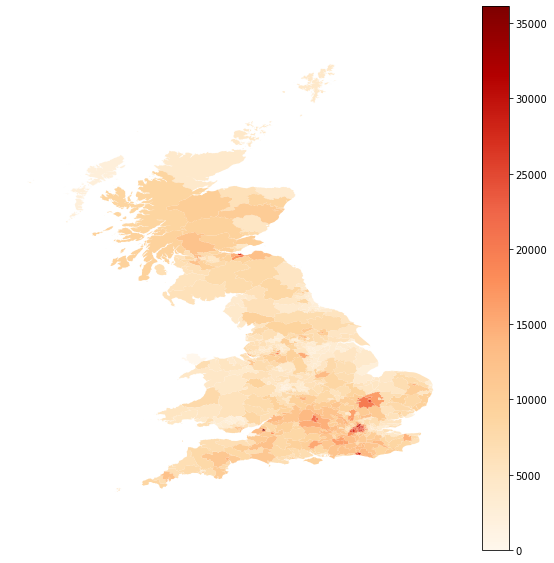

In [25]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax = combined_data.plot(column="signature_count", cmap="OrRd", linewidth=0.8, ax=ax, legend=True)
ax.axis("off")
# The frustratingly large colourbar using legend=True seems to be fixed here. https://github.com/geopandas/geopandas/pull/894,
# waiting for next geopandas release to see the change.

The data we have at the moment includes absolute signature numbers per constituency. However, not every constituency has the same number of constituents. We've included data on electorate numbers so we can caculate a proportion of the electorate who have signed. Unfortunately, we can only find data as of the 2015 election at the moment.

In [27]:
electorate_filepath = os.path.join("..", "data", "information", "ge2015_electorate.csv")
electorate_filepath = Path("../data/map/ge2015_electorate.csv")

electorate_df = pd.read_csv(electorate_filepath)
electorate_df.head()

,constituency_name,electorate
0,Aberavon,49821
1,Aberconwy,45525
2,Aberdeen North,67745
3,Aberdeen South,68056
4,Airdrie and Shotts,66792


In [28]:
combined_data = combined_data.set_index("constituency").join(electorate_df.set_index("constituency_name")).reset_index()
combined_data.head()

,constituency,pcon15cd,st_areasha,st_lengths,geometry,mp,signature_count,electorate
0,Aldershot,E14000530,5.297815e+07,42197.629271,POLYGON ((-0.7754662421455992 51.3319588757355...,Leo Docherty MP,7295.0,72430.0
1,Aldridge-Brownhills,E14000531,4.401654e+07,38590.183714,POLYGON ((-1.905083771468352 52.64320757091168...,Wendy Morton MP,2912.0,60215.0
2,Altrincham and Sale West,E14000532,5.092937e+07,47813.461413,POLYGON ((-2.315991936682887 53.43467382108594...,Sir Graham Brady MP,12896.0,71511.0
3,Amber Valley,E14000533,1.246464e+08,64665.130033,"POLYGON ((-1.33163551111198 53.08098788875827,...",Nigel Mills MP,3971.0,69510.0
4,Arundel and South Downs,E14000534,6.452509e+08,333618.028722,(POLYGON ((-0.5626196767013031 51.055736723659...,Rt Hon Nick Herbert MP,12328.0,77242.0


In [29]:
combined_data.isna().sum()

constituency        0
pcon15cd            0
st_areasha          0
st_lengths          0
geometry            0
mp                  0
signature_count     0
electorate         18
dtype: int64

In [30]:
combined_data["electorate"].fillna(1e10, inplace=True)

In [31]:
combined_data.shape

(632, 8)

In [32]:
combined_data["signature_pc"] = 100 * combined_data["signature_count"] / combined_data["electorate"]

In [33]:
combined_data.head()

,constituency,pcon15cd,st_areasha,st_lengths,geometry,mp,signature_count,electorate,signature_pc
0,Aldershot,E14000530,5.297815e+07,42197.629271,POLYGON ((-0.7754662421455992 51.3319588757355...,Leo Docherty MP,7295.0,72430.0,10.071793
1,Aldridge-Brownhills,E14000531,4.401654e+07,38590.183714,POLYGON ((-1.905083771468352 52.64320757091168...,Wendy Morton MP,2912.0,60215.0,4.836004
2,Altrincham and Sale West,E14000532,5.092937e+07,47813.461413,POLYGON ((-2.315991936682887 53.43467382108594...,Sir Graham Brady MP,12896.0,71511.0,18.033589
3,Amber Valley,E14000533,1.246464e+08,64665.130033,"POLYGON ((-1.33163551111198 53.08098788875827,...",Nigel Mills MP,3971.0,69510.0,5.712847
4,Arundel and South Downs,E14000534,6.452509e+08,333618.028722,(POLYGON ((-0.5626196767013031 51.055736723659...,Rt Hon Nick Herbert MP,12328.0,77242.0,15.960229


In [34]:
print(combined_data["signature_pc"].min())
print(combined_data["signature_pc"].max())

0.0
39.599500197290546


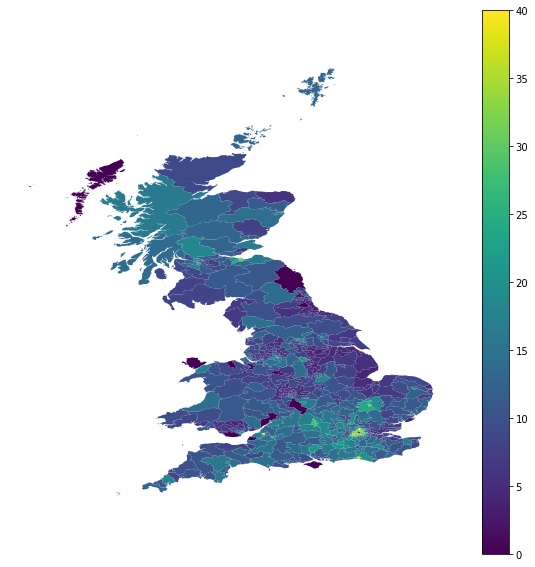

In [35]:
fig, ax = plt.subplots(1, figsize=(10, 10))
combined_data.plot(column="signature_pc", cmap="viridis", linewidth=0.8, ax=ax)
ax.axis("off")

vmin = 0.
vmax = 40.
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)